In [35]:
import os
import keras 
from keras.models import Sequential
from tensorflow.keras.utils import plot_model
from keras.layers import (
    BatchNormalization, 
    Conv2D, 
    Dense, 
    Dropout, 
    Flatten,
    MaxPooling2D)
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder 
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from ann_visualizer.visualize import ann_viz

In [4]:
encoder = OneHotEncoder()
encoder.fit([[1], [0]]) 

# 1 - Tumor
# 0 - Normal

OneHotEncoder()

## Load the Images

In [5]:
data = []
paths = []
labels = []

for r, d, f in os.walk(r'./data/crop/yes'):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r, file))

for path in paths:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        labels.append(encoder.transform([[0]]).toarray())

In [6]:
paths = []
for r, d, f in os.walk(r"./data/crop/no"):
    for file in f:
        if '.jpg' in file:
            paths.append(os.path.join(r, file))

for path in paths:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        data.append(np.array(img))
        labels.append(encoder.transform([[1]]).toarray())

In [7]:
data = np.array(data)
data.shape

(3000, 128, 128, 3)

In [11]:
labels = np.array(labels)
labels = labels.reshape(3000,2)

## Split the data

In [12]:
x_train,x_data,y_train,y_data = train_test_split(data, labels, train_size=0.6, shuffle=True, random_state=0)
x_test,x_val,y_test,y_val = train_test_split(x_data, y_data, train_size=0.5, shuffle=True, random_state=0)

## Define the model

In [13]:
classes = 2

model = Sequential()

model.add(Conv2D(32, kernel_size=(2, 2), input_shape=(128, 128, 3), padding = 'Same'))
model.add(Conv2D(32, kernel_size=(2, 2),  activation ='relu', padding = 'Same'))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size = (2,2), activation ='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size = (2,2), activation ='relu', padding = 'Same'))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(classes, activation='softmax'))

In [14]:
model.compile(loss = "categorical_crossentropy", optimizer='Adamax',  metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      416       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4128      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        8256      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        1

## Train the model

In [15]:
history = model.fit(x_train, 
                    y_train, 
                    epochs = 30, 
                    batch_size = 40, 
                    verbose = 1,
                    validation_data = (x_val, y_val))

Epoch 1/30
45/45 [==============================] - 57s 1s/step - loss: 11.8812 - accuracy: 0.5989 - val_loss: 2.0426 - val_accuracy: 0.5917
Epoch 2/30
45/45 [==============================] - 56s 1s/step - loss: 0.5984 - accuracy: 0.7494 - val_loss: 0.6781 - val_accuracy: 0.7217
Epoch 3/30
45/45 [==============================] - 56s 1s/step - loss: 0.4037 - accuracy: 0.8383 - val_loss: 0.5738 - val_accuracy: 0.7933
Epoch 4/30
45/45 [==============================] - 55s 1s/step - loss: 0.3533 - accuracy: 0.8550 - val_loss: 0.5617 - val_accuracy: 0.8350
Epoch 5/30
45/45 [==============================] - 55s 1s/step - loss: 0.2662 - accuracy: 0.8867 - val_loss: 0.6818 - val_accuracy: 0.8017
Epoch 6/30
45/45 [==============================] - 54s 1s/step - loss: 0.2242 - accuracy: 0.9139 - val_loss: 0.7027 - val_accuracy: 0.8033
Epoch 7/30
45/45 [==============================] - 53s 1s/step - loss: 0.1862 - accuracy: 0.9356 - val_loss: 0.6371 - val_accuracy: 0.8350
Epoch 8/30
45/45 [=

### Plot Loss and and Accuracy

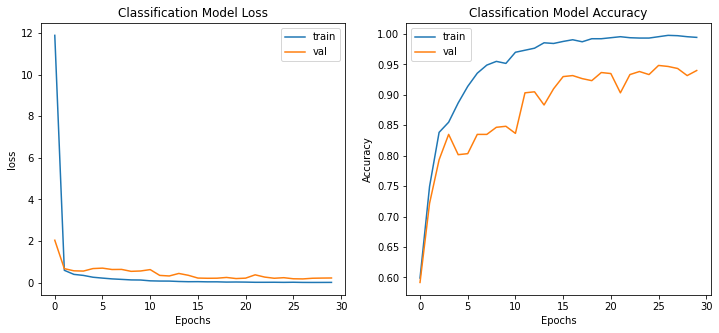

In [25]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);
plt.title("Classification Model Loss");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(history.history['accuracy']);
plt.plot(history.history['val_accuracy']);
plt.title("Classification Model Accuracy");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

## Predict

In [27]:
preds = model.predict_on_batch(x_test)
classification = np.where(preds == np.amax(preds))[1][0]

### Plot Confusion Matrix for Testing Data

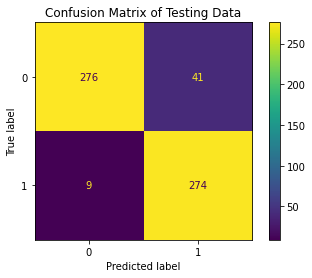

In [42]:
y_true = np.argmax(y_test,axis=1)
y_pred = np.argmax(preds,axis=1)

conf_mat = confusion_matrix(y_true,y_pred)
display = ConfusionMatrixDisplay(conf_mat)
display.plot()
plt.title('Confusion Matrix of Testing Data')
plt.show()

In [3]:
class_rate = (276+274)/(276+41+9+274)
print('Class Rate: ',class_rate)

Class Rate:  0.9166666666666666
